## Содержание: <a name="content"></a>
- [Импорт библиотек, загрузка и просмотр данных](#loading)
- [Предодработка данных](#preprocessing)
- [Исследовательский анализ](#eda)
- [Портрет пользователя каждого региона](#users_profile)
- [Проверка гипотез](#hypothesis_testing)
- [Выводы](#results)

### Импорт библиотек, загрузка и просмотр данных <a name="loading"></a>

[к содержанию](#content)

In [1]:
# Импортируем нужные библиотеки и открываем файлы
import pandas as pd
import numpy as np
from scipy import stats as st
#функция, которая позволит масштабировать графики и видеть координаты xy при наведении курсором на значение
%matplotlib notebook 
import matplotlib.pyplot as plt
#дополнительные средства визуализации
import seaborn as sns 
from scipy.stats import ttest_ind

games = pd.read_csv('/datasets/games.csv')
games.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [2]:
#Посмотрим общую информацию по таблице
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
#Видно, что есть пропуски и неверные форматы в некоторых столбцах
games.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

### Вывод

В полученной таблице 11 столбцов и 16715 строк. Представлена слудующая информация по компьютерным играм:
 - `Name` — название игры
 - `Platform` — платформа
 - `Year_of_Release` — год выпуска
 - `Genre` — жанр игры
 - `NA_sales` — продажи в Северной Америке (миллионы долларов)
 - `EU_sales` — продажи в Европе (миллионы долларов)
 - `JP_sales` — продажи в Японии (миллионы долларов)
 - `Other_sales` — продажи в других странах (миллионы долларов)
 - `Critic_Score` — оценка критиков (максимум 100)
 - `User_Score` — оценка пользователей (максимум 10)
 - `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
 
Для столбца `User_Score` нужно изменить тип данных с object на float.
В столбце `Critic_Score` пропущено более 50% данных (8578 строка из 16715), а в стоблцах `User_Score` и `Rating` по 40% (6701 и 6766 из 16715). Нельзя заполнить пропуски в этих столбцах средними или медианами, даже при условии какой-либо группировки. Необходимо понять причину пропусков и вариант их обратотки.

В столбце `Year_of_Release` 269 пропущенных значений (0,016%), эти пропуски мы заполнять не будем - информация о годе выпуска нам не известна. Также есть по 2 пропуска в столбцах `Name` и `Genre`.

### Предодработка данных <a name="preprocessing"></a>

[к содержанию](#content)

В этом шаге необходимо:
1. Заменить названия столбцов (привести к нижнему регистру);
2. Преобразовать данные в нужные типы;
3. Обработатье пропуски;
4. Посчитайте суммарные продажи во всех регионах и записать их в отдельный столбец.

In [4]:
# Приведем названия столбцов к нижнему регистру
games.columns = games.columns.str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
# Преобразуем данные в столбце "user_score" в тип float
# в столбце есть значение "tbd"
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [6]:
# Посмотрим, как много таких значений
games[games['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


"tbd" расшифровывается как "To Be Determined" и означает, что рейтинг еще не определен (игра собрала недостаточно отзывов/оценок для определения рейтинга). По сути для нас это тоже, что и "NaN" методом replace.  

In [7]:
# Заменим "tbd" на "NaN"
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

Рассмотрим пропуски в столбцах `Critic_Score`, `User_Score` и `Rating`. Пропуски в этих столбцах могут означать, что игры не были оценены геймерами и/или критиками или оценок/отзывов было недостаточно для определения их рейтинга. Мы не можем заполнить пропуски самостоятельно, опираясь на год, жанр или что-то еще. Будет правильнее заполнить пропуски значениями, которых нет в столбцах, как маркерами. Например, "-1" для числовых данных, столбцов `critic_score`, `user_score` и `indefinitely` для `rating`.

Также заполним пропуски в столбцах `Name` и `Genre`: неизвестное название и жанр заполним как "unknown"

In [8]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)
games['rating'] = games['rating'].fillna("indefinitely")
games['name'] = games['name'].fillna("unknown")
games['genre'] = games['genre'].fillna("unknown")
games.isnull().sum()

name                 0
platform             0
year_of_release    269
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
dtype: int64

In [9]:
# Добавим отдельный столбец с суммой продаж по всем регионам
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Вывод

Пропуски были обработаны подстановкой индикаторного значения, так как пропусков очень много и их заполнение какими-либо значениями может сместить наши оценки. Пропуски могли быть связаны с недостаточным количеством оценок/их отсутствием для присвоения рейтингов; отсутствием данных для других параметров. 

Были оставлены пропуске в столбце "year_of_release" - данные неизвестны, и количество пропусков незначительно для данной выборки. В названии некоторых игр указан год, однако, часто бывает, что год в названии игры не соответствует году выпуска (чаще всего в названии стоит год следующий за годом выпуска, например, "FIFA Football 2004" вышла в октябре 2013).

Названия столбцов были приведены к нижнему регистру.

После обработки значения 'tbd' в столбце с рейтингом "user_score", изменили тип данные на float.

Посчитали суммарные продажи во всех регионах.

### Исследовательский анализ данных  <a name="eda"></a>

[к содержанию](#content)

Посмотрим на графике, сколько игр выпускалось в разные годы.

<IPython.core.display.Javascript object>


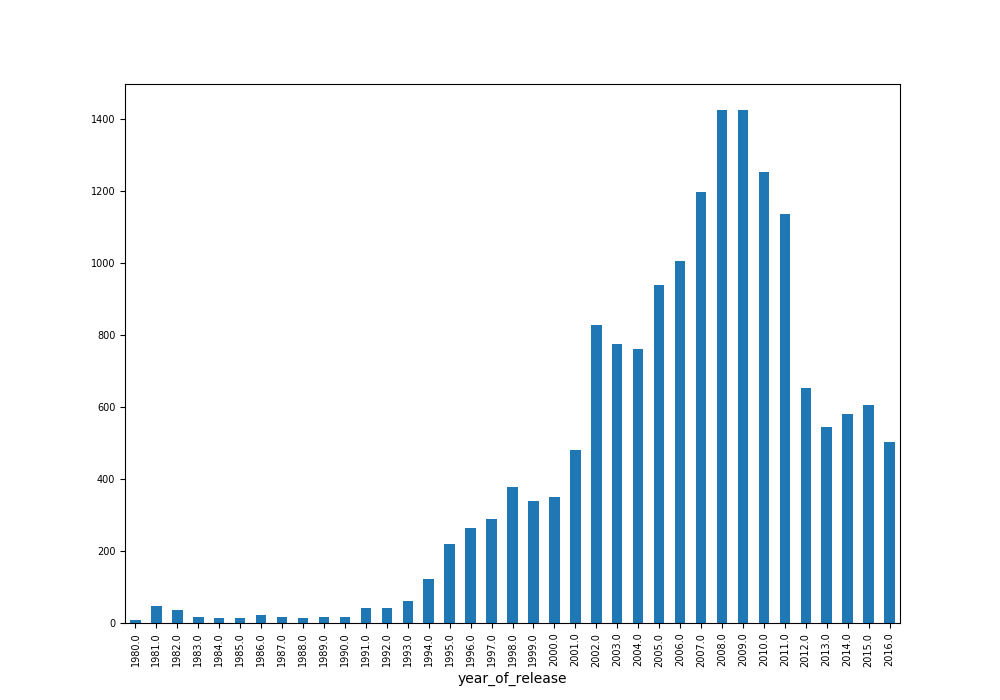

In [10]:
games_in_years = (
    games
    .pivot_table(index='year_of_release', values = 'name', aggfunc='count')
    .plot(kind='bar', figsize=(10,7), legend=False, fontsize=7)
)

#### C 1994 года начали появляться игры на MS-DOS, потом и на Windows, поэтому на графике здесь виден рост. Также заметны скачки в 2002 и максимум в 2008-2009 года. После этого начался спад, в связи с развитием мобильных устройств и уменьшением спроса на компьютерные игры.


Посмотрим, как менялись продажи по платформам. Для платформ с наибольшими суммарными продажами и построим распределение по годам. Посмотрим, за какой характерный срок появляются новые и исчезают старые платформы?

<IPython.core.display.Javascript object>


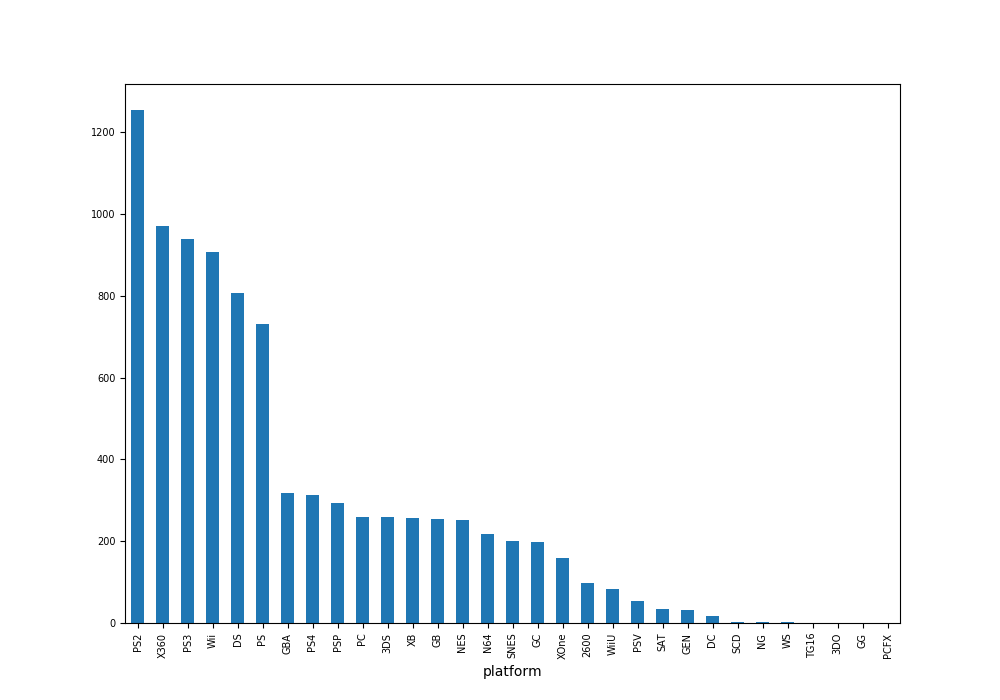

In [11]:
sales_by_platform = (
    games
    .pivot_table(index='platform', values = 'sales_total', aggfunc='sum')
    .sort_values('sales_total', ascending = False)
    .plot(kind='bar', figsize=(10,7), legend=False, fontsize=7)
)

Лидером среди платформ является PS2. Далее идут Xbox360, PS3 и Wii.
Самая редкая - японская платформа PC-FX.



#### Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Возьмем первые 6, для следующих суммарные продажи значительно меньше.

In [12]:
list_platform = games.pivot_table(index='platform', values = 'sales_total', aggfunc='sum').sort_values('sales_total', ascending = False).head(6)

In [13]:
top_platform = list_platform.index
top_platform

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], dtype='object', name='platform')

In [14]:
game_by_platform = games.query('platform in @top_platform')

<IPython.core.display.Javascript object>


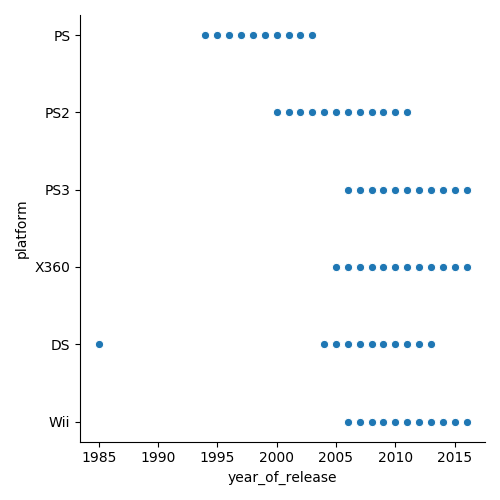

In [15]:
sns.relplot(data = game_by_platform
            ,y = 'platform'
            ,x = 'year_of_release',
            )

За какой характерный срок появляются новые и исчезают старые платформы?

 - `PS` - держалась с 1994 года до 2003, почти 10 лет;
 - `PS2` - с 2000 до 2011 года - 11 лет;
 - `PS3` - с 2006 по настоящее время ещё живёт, но уже не так популярна из-за выхода новой PS4;
 - `X360` - с 2005 по настоящее время;
 - `DS` - вышла в 1985, дальше до ... нет данных (возможно они не собирались в этот период). А с 2004 года популярность начала расти, закончилась в 2013 год - исключая период затишья, 8 лет;
 - `Wii` - с 2006 до нашего времени, но в 2016 уже почти изжила себя - 10 лет.

 
 
#### Таким образом, в среднем платформа живет 10 лет. Дальше выходят новые, удовлетворяющие техническим требованиям новых игр, а старые изживают себя.

Выбререм актуальный период, за который мы будем оценивать данные, чтобы построить предположения на 2017 год.

Ранее мы определили как срок жизни платформы 10 лет. Посмотрим на график продаж по годам для ТОПа.
В период с 2005 по 2016 год представлены данные по всем самым популярным к 2017 году платформам.
Возьмем этот период и отбросим предыдущие годы.

In [16]:
current_period = game_by_platform.query('year_of_release >= 2005')

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах?


<IPython.core.display.Javascript object>


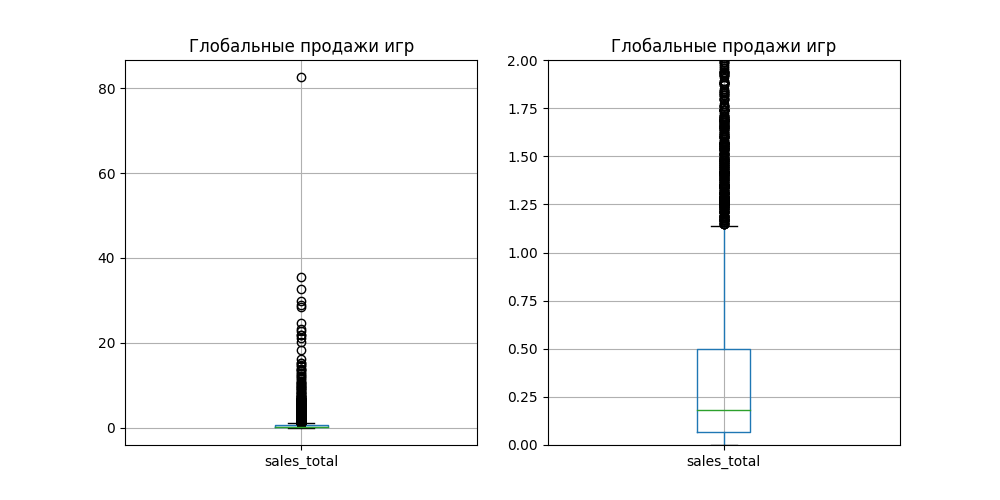

Text(0.5, 1.0, 'Глобальные продажи игр')

In [17]:
fig = plt.figure(figsize=(10,5))

area = fig.add_subplot(1, 2, 1)
ax = current_period.boxplot('sales_total')
ax.set_title("Глобальные продажи игр")

area = fig.add_subplot(1, 2, 2)
ax = current_period.boxplot('sales_total')
plt.ylim(0, 2)
ax.set_title("Глобальные продажи игр")

В среднем, продажи игр составляют до 1,2 млн долларов. Медиана - 0,18 миллиона долларов.

<IPython.core.display.Javascript object>


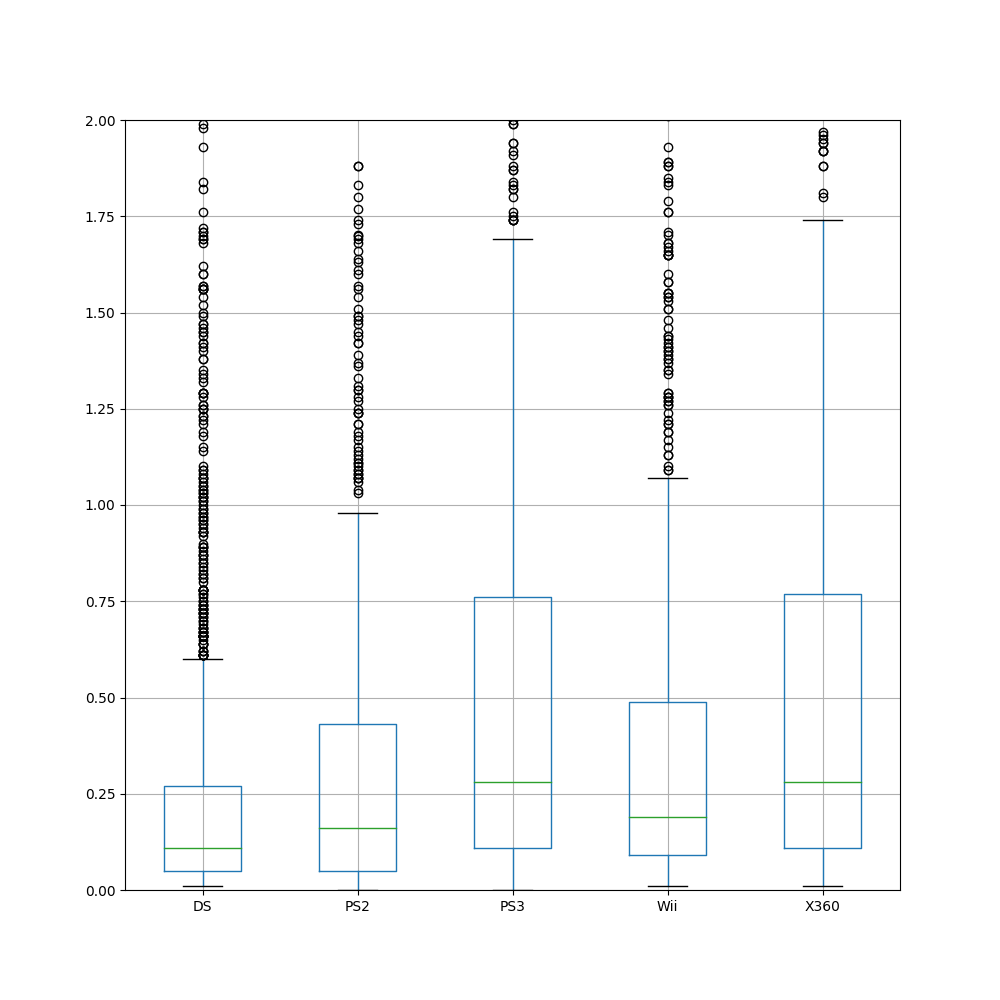

(0, 2)

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
pd.pivot_table(current_period, values='sales_total', index=['name'], columns=['platform']).boxplot(ax=ax, grid=True)
ax.set_ylim(0,2)

#### Медиана по выбранным платформам варьируется от 0,15 до 0,28 млн долларов прибыли за игру. Верхняя граница у двух лидирующих платформ - PS3 и X360 - около 1,7 млн долларов, у остальных - от 1 до 1,1 миллионов долларов. Выделяется DS - у него эти показатели сильное ниже: медиана 0,1 миллиона долларов, верхняя граница - 0,6 млн.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Пострем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

Для анализа возьмем платформу XBox X360, лидера по продажам за исследуемый период.
Посмотрим, как влияют отзывы пользователей.

<IPython.core.display.Javascript object>


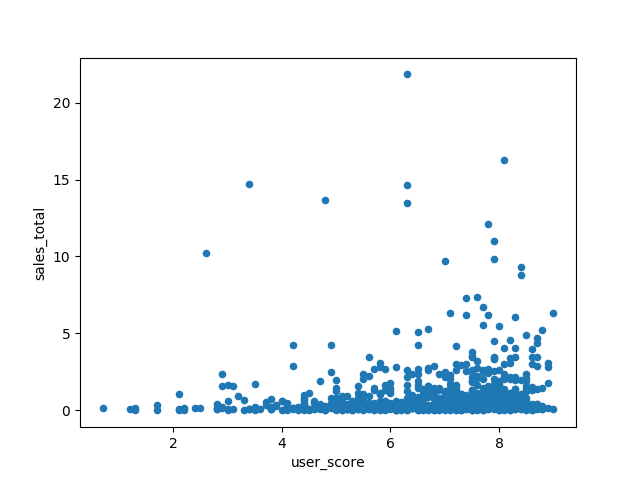

In [19]:
games_x360 = current_period.query('platform == "X360" and user_score > 0')
games_x360.plot(kind='scatter', x='user_score', y='sales_total')

#### Игры с более высоким пользовательским рейтингом приносят больше прибыли. 
#### На диаграмме видны выбросы, которые могут возникать, когда пользователи с нетерпением ждут выхода игры (хорошая реклама, популярность предыдущих версий), но после покупки остаются не вполне довольны и ставят невысокие оценки.

<IPython.core.display.Javascript object>


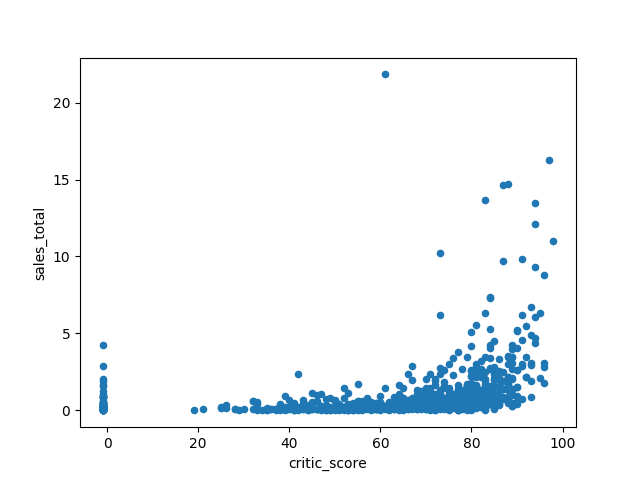

In [20]:
games_x360.plot(kind='scatter', x='critic_score', y='sales_total')

#### Здесь мы видим, что с увеличением рейтинга критиков увеличивается и уровень выручки с продажи игр. Более высокий рейтинг критиков свидетельствует о качестве игры и приносит больше денег.

In [21]:
# Построим матрицу корреляции, нас интересует корреряция между "sales_total" и "user_score", а так же "sales_total" и "critic_score"
corr = games_x360.corr()
corr.style.background_gradient(cmap='coolwarm')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,sales_total
year_of_release,1,-0.00693003,0.0608747,-0.124302,0.0037265,-0.371908,-0.238262,0.0116793
na_sales,-0.00693003,1,0.862023,0.5186,0.967229,0.288963,0.107545,0.985559
eu_sales,0.0608747,0.862023,1,0.49565,0.948726,0.285728,0.108751,0.934959
jp_sales,-0.124302,0.5186,0.49565,1,0.536732,0.257953,0.183939,0.539229
other_sales,0.0037265,0.967229,0.948726,0.536732,1,0.303869,0.122477,0.992812
critic_score,-0.371908,0.288963,0.285728,0.257953,0.303869,1,0.520869,0.29918
user_score,-0.238262,0.107545,0.108751,0.183939,0.122477,0.520869,1,0.114187
sales_total,0.0116793,0.985559,0.934959,0.539229,0.992812,0.29918,0.114187,1


#### Из интересующих нас показателей большее влияет на продажи рейтинг критиков (коэффициент корреляции 0,3 свидетельствует об умеренной силе связи), пользовательский рейтинг оказывает слабое влияние на продажи.

Соотнесем выводы с продажами игр на других платформах.

In [22]:
df_corr = pd.DataFrame({'Платформа' : ['PS2', 'X360', 'PS3', 'Wii', 'DS'],
                       'Влияние оценок критиков' : [current_period.query('platform == "PS2" and user_score > 0')['sales_total'].corr(current_period.query('platform == "PS2" and user_score > 0')['critic_score']), current_period.query('platform == "X360" and user_score > 0')['sales_total'].corr(current_period.query('platform == "X360" and user_score > 0')['critic_score']), current_period.query('platform == "PS3" and user_score > 0')['sales_total'].corr(current_period.query('platform == "PS3" and user_score > 0')['critic_score']), current_period.query('platform == "Wii" and user_score > 0')['sales_total'].corr(current_period.query('platform == "Wii" and user_score > 0')['critic_score']), current_period.query('platform == "DS" and user_score > 0')['sales_total'].corr(current_period.query('platform == "DS" and user_score > 0')['critic_score'])],
                  'Влияние оценок пользователей' : [current_period.query('platform == "PS2" and user_score > 0')['sales_total'].corr(current_period.query('platform == "PS2" and user_score > 0')['user_score']), current_period.query('platform == "X360" and user_score > 0')['sales_total'].corr(current_period.query('platform == "X360" and user_score > 0')['user_score']), current_period.query('platform == "PS3" and user_score > 0')['sales_total'].corr(current_period.query('platform == "PS3" and user_score > 0')['user_score']), current_period.query('platform == "Wii" and user_score > 0')['sales_total'].corr(current_period.query('platform == "Wii" and user_score > 0')['user_score']), current_period.query('platform == "DS" and user_score > 0')['sales_total'].corr(current_period.query('platform == "DS" and user_score > 0')['user_score'])],})

df_corr.head()

,Платформа,Влияние оценок критиков,Влияние оценок пользователей
0,PS2,0.257023,0.190395
1,X360,0.299180,0.114187
2,PS3,0.299975,0.128416
3,Wii,0.141333,0.112831
4,DS,0.150579,0.135124


#### Корреляции между продажами и оценкой критиков по платформам PS2, X360 и PS3 умеренная, а для Wii и DS, слабая. Оценки пользователей везде имеют слабое влияние на продажи.

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

<IPython.core.display.Javascript object>


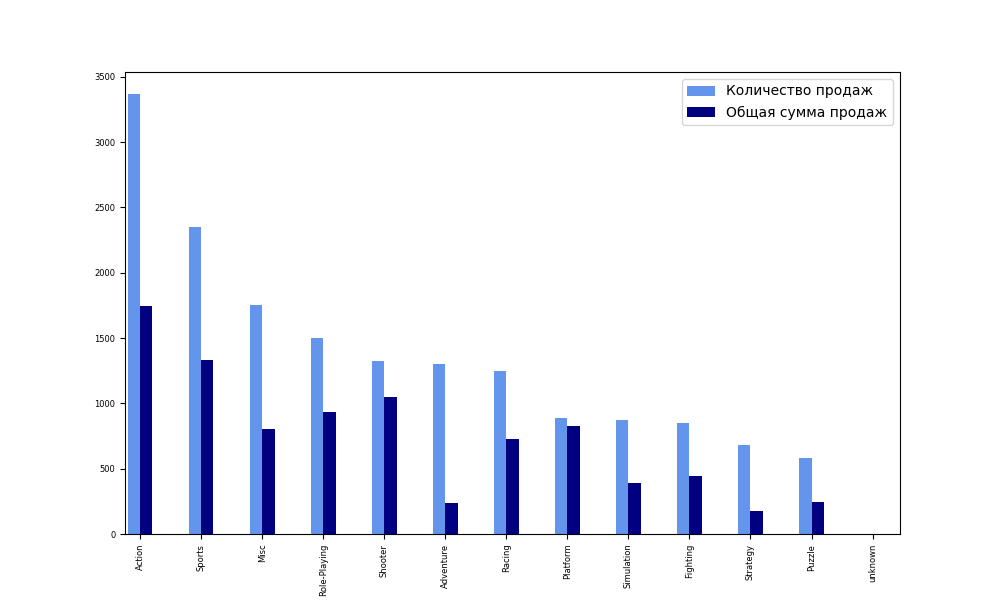

In [23]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', figsize=(10,6), ax=ax, width=0.2, color='cornflowerblue', position=1, fontsize=6)

plot2 = pivot['sales_total']
plot2.plot(kind='bar', figsize=(10,6), ax=ax, width=0.2, color='navy', position=0)


ax.legend(['Количество продаж', 'Общая сумма продаж'])

Больше всего игр жанра `Action`, они же лидируют по продажам. За ними идут игры жанра `Sports` (по количеству игр заметно уступает, а по продажам отставание небольшое). 
Это можно объяснить тем, спортивные игры чаще выходят на консолях и стоят дороже игр для ПК.

В конце списка по количеству игр `Fighting`, `Strategy` и `Puzzle`; по продажам `Puzzle`, `Adventure` и `Strategy`.

### Портрет пользователя каждого региона  <a name="users_profile"></a>

[к содержанию](#content)

Необходимо определить для пользователя каждого региона (NA, EU, JP):
 - Самые популярные платформы (топ-5). Описать различия в долях продаж.
 - Самые популярные жанры (топ-5). Пояснить разницу.
 - Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [24]:
# Используем функцию для создания графиков по платформам и жанрам в кадом регионе
def top_in_regions(groupby, region, ax, y_lim):
    pivot = games.groupby(groupby).agg({region: 'sum'}).sort_values(by=region, ascending=False)[:5]
    df_title = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    df_color = {'na_sales': 'cornflowerblue', 'eu_sales': 'mediumblue', 'jp_sales': 'navy'}
    plot = pivot.plot(kind='bar', ec='black', title=df_title[region], ax=axes[ax], color=df_color[region], 
                   fontsize=9, rot=15, ylim = (0, y_lim))
    plot.legend(prop={'size':10})
    plot.set_xlabel('')
    plot.title.set_size(10)

#### Построим графики для самых популярных платформ (топ-5) в каждом регионе

<IPython.core.display.Javascript object>


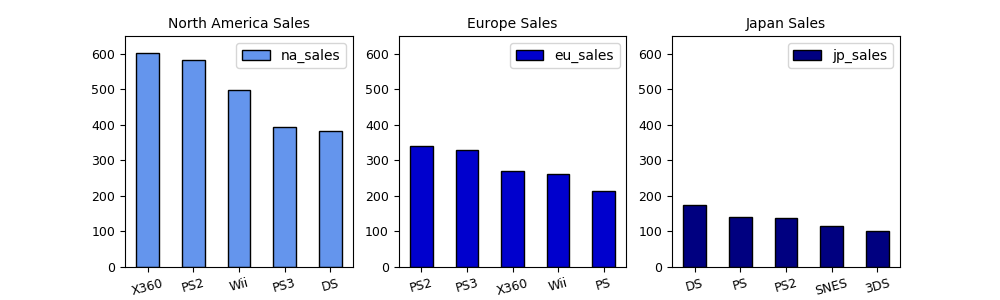

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

top_in_regions('platform', 'na_sales', 0, 650)
top_in_regions('platform', 'eu_sales', 1, 650)
top_in_regions('platform', 'jp_sales', 2, 650)

 - В Северной Америке лидерами стали X360 и PS2, немного отстает Wii, затем PS3 и DS.

 - В Европе на первых местах PS2 и PS3 (почти одинаковый объем продаж), за ними X360, Wii и PS.

 - В Японии лидерирует DS, за ним PS и PS2. Замыкают топ-5 японские SNES и 3DS.

#### Построим графики для самых популярных жанров (топ-5) в каждом регионе

<IPython.core.display.Javascript object>


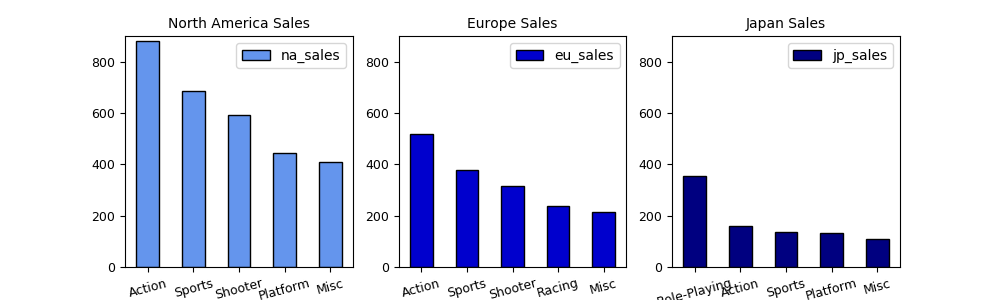

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

top_in_regions('genre', 'na_sales', 0, 900)
top_in_regions('genre', 'eu_sales', 1, 900)
top_in_regions('genre', 'jp_sales', 2, 900)

 - В Северной Америке и Европе популярны одни и те же жанры (за исключением 4 места в рейтенге: в Северной Америке больше играют в Pratform, а в Европе чаще выбирают Racing).
 - В Японии на первом месте с большим отрывом Role-Playning. Далее Action и Sports.

Теперь посмотрим влияет ли рейтинг ESRB на продажи в отдельном регионе. 

Для этого добавим новый столбец, где расшифруем значение рейтинга.

In [27]:
#В слоблце присутствует рейтинг 'K-A' - устаревшее обозначение 'E'. Заменим устаревшее значение
games['rating'] = games['rating'].replace('K-A', 'E')

#Создадим словарь
ESRB_dictionary = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 'E10+': '>10 лет'}
games['ESRB_meaning'] = games[games['rating'].notnull()]['rating'].map(ESRB_dictionary)

#### Построим графики по рейтингам в каждом регионе

<IPython.core.display.Javascript object>


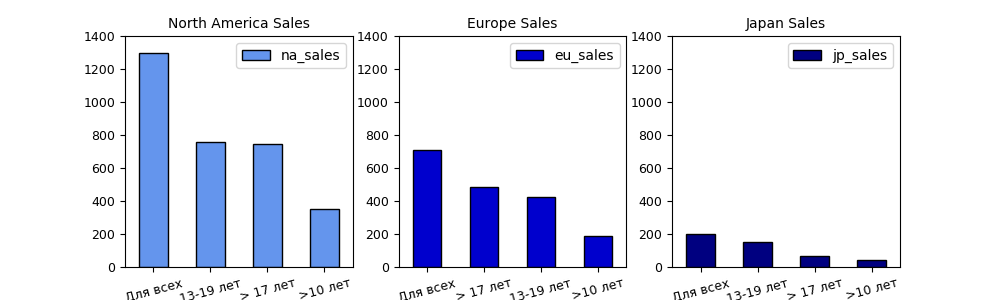

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

top_in_regions('ESRB_meaning', 'na_sales', 0, 1400)
top_in_regions('ESRB_meaning', 'eu_sales', 1, 1400)
top_in_regions('ESRB_meaning', 'jp_sales', 2, 1400)

Везде на первом месте идут игры "для всех". В Северной Америке и в Европе игры с рейтингом "13-19 лет" и "старше 17 лет" продаются примерно поровну, тогда как в Японии второе место (игры для лиц от 13 до 19 лет) сильно превышает третье (игры для лиц старше 17 лет)

### Проверка гипотез  <a name="hypothesis_testing"></a>

[к содержанию](#content)

У нас есть две гипотезы, которые нужно проверить:
 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
 - Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

В обоих случаях у нас выборки независимы между собой, поэтому для проверки гипотез будем использовать t-критерий Стьюдента.
Возьмем пороговое значение alpha = 0.05

Начнем с первой пипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#### Формулировка нулевой гипотезы H₀ будет звучать так: средние пользовательские рейтинги платформ Xbox One и PC равны.
#### Альтернативная гипотеза H₁: средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [29]:
xbox_one_ratings = games[(games['platform'] == 'XOne') & (games['user_score'] > 0)]['user_score']
pc_ratings = games[(games['platform'] == 'PC') & (games['user_score'] > 0)]['user_score']

alpha = .05 
results = st.ttest_ind(
    xbox_one_ratings, 
    pc_ratings)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3896435533548819e-05
Отвергаем нулевую гипотезу


У нас есть основание отвергнуть нулевую гипотезу о равенстве рейтингов платформ Xbox One и PC.

Перейдем к следующей пипотезе: средние пользовательские рейтинги жанров Action и Sports одинаковые.

#### Формулировка нулевой гипотезы H₀ будет звучать так: средние пользовательские рейтинги жанров Action и Sports равны.
#### Альтернативная гипотеза H₁: средние пользовательские рейтинги жанров Action и Sports не равны.

In [30]:
action_ratings = games[(games['genre'] == 'Action') & (games['user_score'] > 0)]['user_score']
pc_ratings = games[(games['genre'] == 'Sports') & (games['user_score'] > 0)]['user_score']

alpha = .05 
results = st.ttest_ind(
    action_ratings, 
    pc_ratings)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


Есть основания считать, что средние пользовательские рейтинги жанров Action и Sports одинаковые.

### Шаг 6. Общий вывод  <a name="results"></a>

[к содержанию](#content)

Платформы "живут" около 10 лет, затем сменяются более усевершенствованными. При этом мы наблюдаем снижение продаж как по отдельным платформам, так и в целом на рынке компьютерных игр, которое скорее всего сохраниться и в дальнейшем. Большую роль здесь сыграло развитие мобильных устройств и социальные сети.

На суммарные продажи больше всего влияют оценки критиков, в то время как оценки пользователей слабо влияют на продажи.

В Северной Америке и Европе наиболее популярны жанры Action и Sports, а в Японии - Role-Playning.